##import

In [ ]:
pip install pycaret

In [ ]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import holidays
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.regression import *

메소드

In [ ]:
def check_holiday(target_df):
  # 주말 여부 확인하여 저장, 주말:true 평일:false
  target_df['holiday'] = target_df['일시'].dt.weekday >= 5

  # 한국의 공휴일 여부 확인하여 저장
  korea_holidays = holidays.KR()
  target_df['공휴일'] = target_df['일시'].apply(lambda x: x in korea_holidays)

  # 공휴일인 경우 holiday 값을 true로 변경
  target_df.loc[target_df['공휴일'], 'holiday'] = True

  return target_df

def make_ymd_feature(target_df):
  # 일시 데이터를 년, 월, 일, 시간으로 나누어 새로운 컬럼 추가
  #target_df['년'] = target_df['일시'].dt.year
  target_df['월'] = target_df['일시'].dt.month
  target_df['일'] = target_df['일시'].dt.day
  target_df['시간'] = target_df['일시'].dt.hour

  return target_df

# 불쾌지수 계산 함수 정의
def calculate_discomfort_index(temperature, humidity):
    return 0.81 * temperature + 0.01 * humidity * (0.99 * temperature - 14.3) + 46.3

def smape_fnc(true, pred):
  v = 2*abs(pred-true)/(abs(pred)+abs(true))
  output=np.mean(v)*100
  return output

## train 데이터

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/train.csv')

# 강수량, 일조, 일사 컬럼 삭제
df = df.drop(columns=['강수량(mm)', '일조(hr)', '일사(MJ/m2)'])

# 풍속과 습도 값이 NaN일 때 전 행의 값으로 치환
df['풍속(m/s)'].fillna(method='ffill', inplace=True)
df['습도(%)'].fillna(method='ffill', inplace=True)

# 기온 Min-Max 정규화 수행
scaler = MinMaxScaler()
df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# 불쾌지수 계산 후 새로운 컬럼 추가
df['불쾌지수'] = calculate_discomfort_index(df['기온(C)'], df['습도(%)'])


# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
df = check_holiday(df)

# 년, 월, 일, 시간 컬럼 추가
df = make_ymd_feature(df)

# 요일 컬럼 추가
df['요일'] = df['일시'].dt.dayofweek  # 요일을 0(월요일)부터 6(일요일)까지의 정수로 저장

# 컬럼 삭제
df.drop(columns=['num_date_time','공휴일','기온(C)'], inplace=True) # '일시'

# csv 파일로 저장
#df.to_csv('train_p.csv', index=False)
train_df = df.copy()

train_df

,건물번호,일시,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,시간,요일
0,1,2022-06-01 00:00:00,0.9,42.0,1085.28,0.314815,63.09388,False,6,1,0,2
1,1,2022-06-01 01:00:00,1.1,45.0,1047.36,0.292593,62.46400,False,6,1,1,2
2,1,2022-06-01 02:00:00,1.5,45.0,974.88,0.281481,62.08735,False,6,1,2,2
3,1,2022-06-01 03:00:00,1.4,48.0,953.76,0.244444,60.89884,False,6,1,3,2
4,1,2022-06-01 04:00:00,2.8,43.0,986.40,0.307407,62.88788,False,6,1,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...
203995,100,2022-08-24 19:00:00,0.9,86.0,881.04,0.481481,72.38034,False,8,24,19,2
203996,100,2022-08-24 20:00:00,1.3,86.0,798.96,0.455556,71.21736,False,8,24,20,2
203997,100,2022-08-24 21:00:00,1.0,92.0,825.12,0.414815,69.79704,False,8,24,21,2
203998,100,2022-08-24 22:00:00,0.3,94.0,640.08,0.403704,69.41060,False,8,24,22,2


In [ ]:
df.describe()

,건물번호,기온(C),풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,월,일,시간,요일
count,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,204000.000000,203991.000000,204000.000000,204000.000000,204000.000000,204000.000000
mean,50.500000,25.543524,2.134052,78.716518,2451.036462,0.571982,75.419717,6.929412,14.835294,11.500000,2.988235
std,28.866141,3.779523,1.358146,15.080496,2440.648858,0.139982,5.460523,0.793923,8.446178,6.922204,1.991127
min,1.000000,10.100000,0.000000,13.000000,0.000000,0.000000,50.481070,6.000000,1.000000,0.000000,0.000000
25%,25.750000,23.400000,1.200000,69.000000,1085.760000,0.492593,72.551720,6.000000,8.000000,5.750000,1.000000
50%,50.500000,25.700000,2.000000,81.000000,1766.400000,0.577778,76.268500,7.000000,15.000000,11.500000,3.000000
75%,75.250000,28.100000,2.800000,91.000000,2970.000000,0.666667,79.366630,8.000000,22.000000,17.250000,5.000000
max,100.000000,37.100000,13.300000,100.000000,25488.400000,1.000000,87.789790,8.000000,31.000000,23.000000,6.000000


## buliding_info 데이터

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/building_info.csv')

#  '-'인 경우 0으로 대체
df = df.replace('-', 0)

# 건물유형 원-핫 인코딩
one_hot_encoded = pd.get_dummies(df['건물유형'])
df = pd.concat([df, one_hot_encoded], axis=1)

'''
from sklearn.preprocessing import LabelEncoder
# 라벨 인코더 생성 및 적용
label_encoder = LabelEncoder()
df['건물유형_라벨'] = label_encoder.fit_transform(df['건물유형'])
'''

# 문자열을 숫자로 변환
df['태양광용량(kW)'] = df['태양광용량(kW)'].astype(float)
df['ESS저장용량(kWh)'] = df['ESS저장용량(kWh)'].astype(float)
df['PCS용량(kW)'] = df['PCS용량(kW)'].astype(float)

# 컬럼 삭제
df.drop(columns=['PCS용량(kW)'], inplace=True) #'건물유형'

# csv 파일로 저장
#df.to_csv('building_info_p.csv', index=False)
binfo_df = df.copy()

binfo_df

,건물번호,건물유형,연면적(m2),냉방면적(m2),태양광용량(kW),ESS저장용량(kWh),건물기타,공공,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,1,건물기타,110634.00,39570.00,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
1,2,건물기타,122233.47,99000.00,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
2,3,건물기타,171243.00,113950.00,40.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
3,4,건물기타,74312.98,34419.62,60.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0
4,5,건물기타,205884.00,150000.00,0.0,2557.0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,호텔및리조트,93314.00,60500.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
96,97,호텔및리조트,55144.67,25880.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
97,98,호텔및리조트,53578.62,17373.75,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1
98,99,호텔및리조트,53499.00,40636.00,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,1


## test 데이터

In [ ]:
# 데이터 불러오기
df = pd.read_csv('/content/test.csv')

# 불쾌지수 계산 후 새로운 컬럼 추가
df['불쾌지수'] = calculate_discomfort_index(df['기온(C)'], df['습도(%)'])

# 기온 Min-Max 정규화 수행
scaler = MinMaxScaler()
df[['기온_정규화']] = scaler.fit_transform(df[['기온(C)']])

# '일시' 열을 날짜 형식으로 변환
df['일시'] = pd.to_datetime(df['일시'], format='%Y%m%d %H')

# holiday 컬럼 추가
df = check_holiday(df)

# 년, 월, 일, 시간 컬럼 추가
df = make_ymd_feature(df)

# 건물번호로 binfo_df 연결 (left join)
test_df = pd.merge(df, binfo_df, on='건물번호', how='left')

# 컬럼 삭제
test_df.drop(columns=['num_date_time','강수량(mm)', '일시', '공휴일', '건물번호', '건물유형', '기온(C)'], inplace=True)

# csv 파일로 저장
#test_df.to_csv('test_p.csv', index=False)

test_df

,풍속(m/s),습도(%),불쾌지수,기온_정규화,holiday,월,일,시간,연면적(m2),냉방면적(m2),...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,2.2,72,71.78980,0.562189,False,8,25,0,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
1,0.9,72,71.02840,0.537313,False,8,25,1,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
2,1.5,75,70.81675,0.522388,False,8,25,2,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
3,1.3,78,70.11262,0.492537,False,8,25,3,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
4,1.0,77,69.56514,0.477612,False,8,25,4,110634.00,39570.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16795,0.9,84,71.22400,0.512438,False,8,31,19,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
16796,0.4,95,68.95035,0.422886,False,8,31,20,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
16797,0.4,98,68.24604,0.398010,False,8,31,21,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1
16798,1.1,97,68.01203,0.393035,False,8,31,22,57497.84,40035.23,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
test_df.columns.tolist()

['풍속(m/s)',
 '습도(%)',
 '불쾌지수',
 '기온_정규화',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']

## 알고리즘

In [ ]:
# 건물번호로 train_df와 binfo_df 연결 (left join)
combined_df = pd.merge(train_df, binfo_df, on='건물번호', how='left')

# '건물번호, '태양광용량(kW)', 'ESS저장용량(kWh)', '기온(C)', '건물유형','일시','요일',
selected_columns = ['풍속(m/s)',
 '습도(%)',
 '전력소비량(kWh)',
 '기온_정규화',
 '불쾌지수',
 'holiday',
 '월',
 '일',
 '시간',
 '연면적(m2)',
 '냉방면적(m2)',
 '태양광용량(kW)',
 'ESS저장용량(kWh)',
 '건물기타',
 '공공',
 '대학교',
 '데이터센터',
 '백화점및아울렛',
 '병원',
 '상용',
 '아파트',
 '연구소',
 '지식산업센터',
 '할인마트',
 '호텔및리조트']
combined_df = combined_df[selected_columns]

combined_df

,풍속(m/s),습도(%),전력소비량(kWh),기온_정규화,불쾌지수,holiday,월,일,시간,연면적(m2),...,대학교,데이터센터,백화점및아울렛,병원,상용,아파트,연구소,지식산업센터,할인마트,호텔및리조트
0,0.9,42.0,1085.28,0.314815,63.09388,False,6,1,0,110634.00,...,0,0,0,0,0,0,0,0,0,0
1,1.1,45.0,1047.36,0.292593,62.46400,False,6,1,1,110634.00,...,0,0,0,0,0,0,0,0,0,0
2,1.5,45.0,974.88,0.281481,62.08735,False,6,1,2,110634.00,...,0,0,0,0,0,0,0,0,0,0
3,1.4,48.0,953.76,0.244444,60.89884,False,6,1,3,110634.00,...,0,0,0,0,0,0,0,0,0,0
4,2.8,43.0,986.40,0.307407,62.88788,False,6,1,4,110634.00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203995,0.9,86.0,881.04,0.481481,72.38034,False,8,24,19,57497.84,...,0,0,0,0,0,0,0,0,0,1
203996,1.3,86.0,798.96,0.455556,71.21736,False,8,24,20,57497.84,...,0,0,0,0,0,0,0,0,0,1
203997,1.0,92.0,825.12,0.414815,69.79704,False,8,24,21,57497.84,...,0,0,0,0,0,0,0,0,0,1
203998,0.3,94.0,640.08,0.403704,69.41060,False,8,24,22,57497.84,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
combined_df.columns.tolist()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

# Feature와 Target을 분리합니다.
X = combined_df.drop(columns=['전력소비량(kWh)'])
y = combined_df['전력소비량(kWh)']

# Train과 Test 세트로 데이터를 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBoost 회귀 모델을 생성하고 학습합니다.
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# 모델의 성능 평가를 위해 SMAPE 함수를 정의합니다.
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# 모델의 예측값을 생성합니다.
y_pred = xgb_model.predict(X_test)

# SMAPE를 계산하여 모델의 성능을 평가합니다.
smape_score = smape_fnc(y_test, y_pred)
print(f"SMAPE: {smape_score:.5f}")



##pycaret

In [ ]:
# pycaret 설정
exp1 = setup(data=combined_df, target='전력소비량(kWh)')

# 모델 학습 및 비교
best_model = compare_models()

# 결과 출력
print(best_model)


,Description,Value
0,Session id,8725
1,Target,전력소비량(kWh)
2,Target type,Regression
3,Original data shape,"(204000, 25)"
4,Transformed data shape,"(204000, 25)"
5,Transformed train set shape,"(142800, 25)"
6,Transformed test set shape,"(61200, 25)"
7,Numeric features,23
8,Rows with missing values,0.0%
9,Preprocess,True


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,04:18:50
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,117.5613,66106.6732,256.7819,0.9890,0.1249,0.0819,2.4600
knn,K Neighbors Regressor,251.7456,238225.6859,488.0032,0.9603,0.2054,0.1564,14.3300
ridge,Ridge Regression,1260.1825,4140297.1000,2034.5051,0.3100,0.6781,0.7682,0.1730
br,Bayesian Ridge,1261.0433,4141319.9250,2034.7580,0.3099,0.6797,0.7688,0.4870
lr,Linear Regression,1261.6798,4143315.8500,2035.2476,0.3095,0.6820,0.7698,1.6420
llar,Lasso Least Angle Regression,1262.4007,4143486.7250,2035.2893,0.3095,0.6815,0.7707,0.3090
lasso,Lasso Regression,1259.3813,4143866.9000,2035.3789,0.3094,0.6756,0.7688,6.6370
en,Elastic Net,1384.2520,5337206.4500,2309.7925,0.1109,0.7407,0.9271,5.1330
omp,Orthogonal Matching Pursuit,1491.4575,5979119.9000,2444.7911,0.0039,0.8137,1.0520,0.1680
huber,Huber Regressor,1416.0274,6733183.8477,2594.0221,-0.1214,0.7777,0.6843,2.8560


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,87.1486,31720.6989,178.0540,0.9947,0.0916,0.0611,84.9820
rf,Random Forest Regressor,92.5697,35110.3829,187.3421,0.9941,0.0942,0.0647,114.5960
dt,Decision Tree Regressor,117.5613,66106.6732,256.7819,0.9890,0.1249,0.0819,2.4600
xgboost,Extreme Gradient Boosting,165.6196,69339.0180,263.2335,0.9884,0.1552,0.1275,21.6840
lightgbm,Light Gradient Boosting Machine,222.4930,105542.2152,324.8435,0.9824,0.1888,0.1706,2.0440
knn,K Neighbors Regressor,251.7456,238225.6859,488.0032,0.9603,0.2054,0.1564,14.3300
gbr,Gradient Boosting Regressor,515.1160,503011.2852,709.1654,0.9161,0.3581,0.3703,22.6850
ada,AdaBoost Regressor,1407.1909,2611299.5527,1615.7404,0.5645,0.8284,1.2667,16.7330
ridge,Ridge Regression,1260.1825,4140297.1000,2034.5051,0.3100,0.6781,0.7682,0.1730
br,Bayesian Ridge,1261.0433,4141319.9250,2034.7580,0.3099,0.6797,0.7688,0.4870


ExtraTreesRegressor(n_jobs=-1, random_state=8725)


In [ ]:
# 모델 생성
et_model = create_model('et')
rf_model = create_model('rf')
dt_model = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,87.8505,30260.7972,173.9563,0.9950,0.0882,0.0485
1,86.6777,31595.1985,177.7504,0.9948,0.0897,0.0485
2,86.3176,30036.8842,173.3115,0.9949,0.0884,0.0487
3,87.1667,33194.3072,182.1930,0.9947,0.0938,0.0495
4,87.1837,30360.3999,174.2424,0.9951,0.0845,0.0471
5,87.6811,32279.5432,179.6651,0.9942,0.0876,0.0483
6,87.4109,33369.5576,182.6734,0.9946,0.1044,0.1774
7,86.7888,34025.4948,184.4600,0.9942,0.1036,0.0470
8,86.2539,29643.4305,172.1727,0.9952,0.0851,0.0474


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,05:37:46
Status,. . . . . . . . . . . . . . . . . .,Fitting 10 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Random Forest Regressor


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
# 선택한 모델 튜닝
et_tune_model = tune_model('et')
rf_tune_model = tune_model('rf')
dt_tune_model = tune_model('dt')


In [ ]:
# 변수 중요도 그래프
plot_model(estimator = tuned_adaboost, plot = 'feature')

# 모델 평가
evaluate_model(tuned_adaboost)

In [ ]:
# 예측
ada_final = finalize_model(tuned_adaboost)
predict_model(ada_final,test_df)

## 스태킹

랜덤포레스트, svm, xgb

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error

# 데이터프레임에서 필요한 열만 선택
X = combined_df.drop(columns=['전력소비량(kWh)'])
y = combined_df['전력소비량(kWh)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 모델 생성
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
svm_model = SVR()
xgb_model = XGBRegressor()

# 스태킹 모델 생성
estimators = [('rf', rf_model), ('svm', svm_model), ('xgb', xgb_model)]
stacking_model = StackingRegressor(estimators=estimators, final_estimator=RandomForestRegressor(n_estimators=100, random_state=42))

# 스태킹 모델 학습
stacking_model.fit(X_train, y_train)

# 테스트 데이터로 예측
y_pred = stacking_model.predict(X_test)

# 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error: {rmse}")

smape = smape_fnc(y_test, y_pred)
print(f"smape: {smape}")


# test 예측
y_pred_submit = stacking_model.predict(test_df)



Extra Trees Regressor, Random Forest Regressor, Decision Tree Regressor

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 데이터프레임에서 필요한 열만 선택
X = combined_df.drop(columns=['전력소비량(kWh)'])
y = combined_df['전력소비량(kWh)']

# 학습 데이터와 테스트 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 기본 모델 학습 및 예측
dt_regressor = DecisionTreeRegressor(random_state=42)
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
et_regressor = ExtraTreesRegressor(n_estimators=100, random_state=42)

dt_regressor.fit(X_train, y_train)
rf_regressor.fit(X_train, y_train)
et_regressor.fit(X_train, y_train)

dt_pred = dt_regressor.predict(X_test)
rf_pred = rf_regressor.predict(X_test)
et_pred = et_regressor.predict(X_test)

# 기본 모델 예측 결과 저장
base_model_predictions = [dt_pred, rf_pred, et_pred]

# Meta 모델 학습 및 예측
meta_model = LinearRegression()
meta_model.fit(np.array(base_model_predictions).T, y_test)

stacked_predictions = meta_model.predict(np.array(base_model_predictions).T)

# 스태킹 모델의 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, stacked_predictions))
print(f"Stacking Model RMSE: {rmse}")


# test 예측
dt_pred_submit = dt_regressor.predict(test_df)
rf_pred_submit = rf_regressor.predict(test_df)
et_pred_submit = et_regressor.predict(test_df)

# 기본 모델 예측 결과 저장
base_model_predictions_submit = np.array([dt_pred_submit, rf_pred_submit, et_pred_submit]).T

# Meta 모델 학습 및 예측
stacked_predictions_submit = meta_model.predict(base_model_predictions_submit)


## 그래프

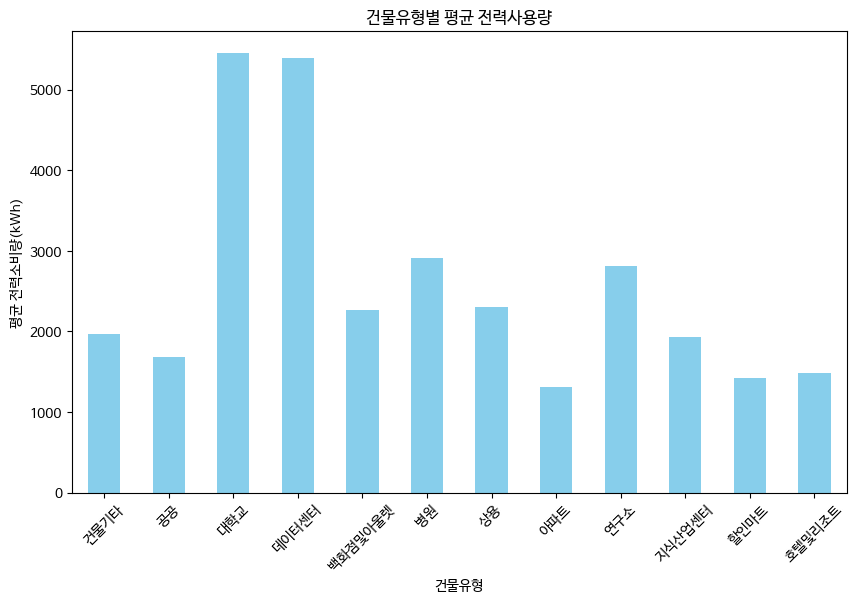

In [ ]:
# 건물유형별 전력사용량의 평균 계산
mean_by_building_type = combined_df.groupby('건물유형')['전력소비량(kWh)'].mean()

# 그래프 그리기
plt.rc('font', family='NanumBarunGothic')
plt.figure(figsize=(10, 6))
mean_by_building_type.plot(kind='bar', color='skyblue')
plt.title('건물유형별 평균 전력사용량')
plt.xlabel('건물유형')
plt.ylabel('평균 전력소비량(kWh)')
plt.xticks(rotation=45)
plt.show()

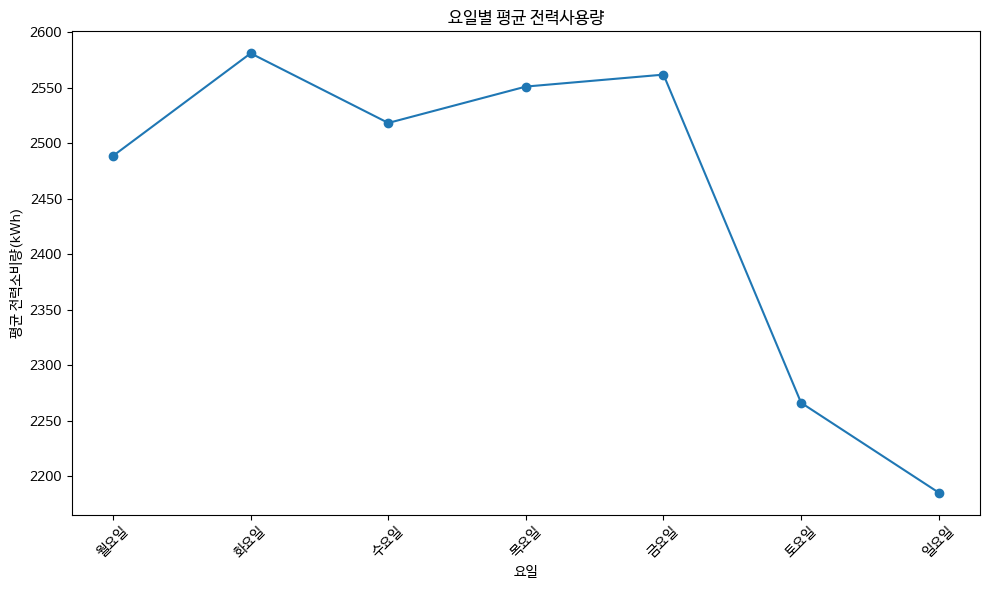

In [ ]:
# 요일별 전력사용량의 평균 계산
weekday_df = combined_df.copy()
weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']
weekday_df = weekday_df.groupby('요일')['전력소비량(kWh)'].mean().reindex(range(7))

plt.figure(figsize=(10, 6))
plt.plot(weekday_df.index, weekday_df.values, marker='o')
plt.xlabel('요일')
plt.ylabel('평균 전력소비량(kWh)')
plt.title('요일별 평균 전력사용량')
plt.xticks(range(7), weekday_order, rotation=45)
plt.tight_layout()
plt.show()

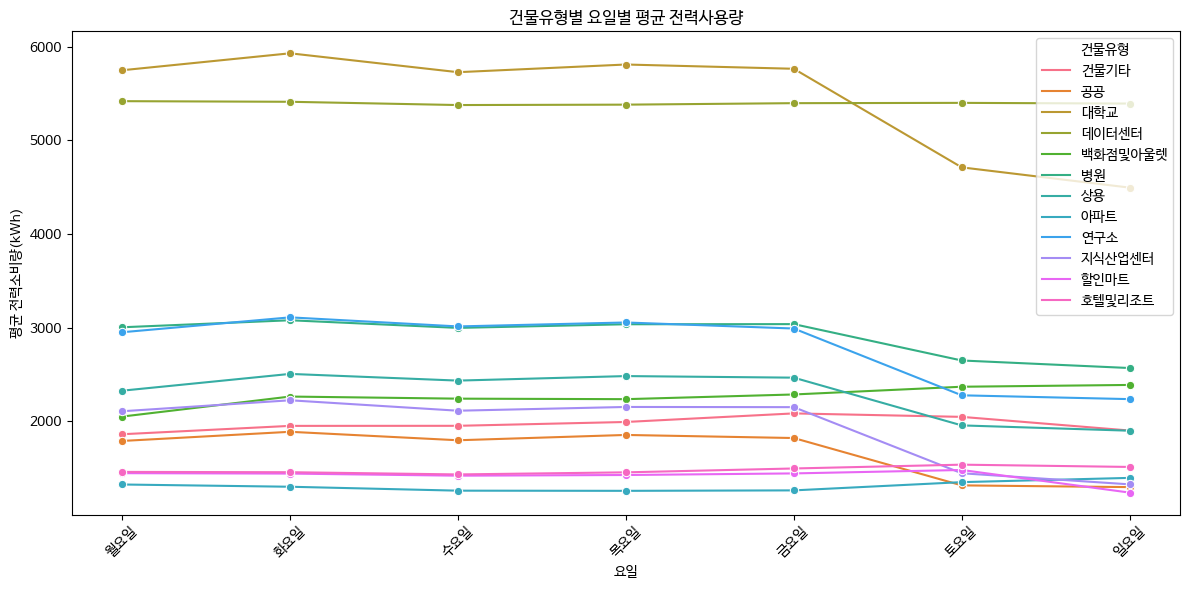

In [ ]:
# 건물유형별 요일별 평균 전력소비량 계산
building_type_weekday_df = combined_df.groupby(['건물유형', '요일'])['전력소비량(kWh)'].mean().reset_index()

# 요일 순서 설정
weekday_order = ['월요일', '화요일', '수요일', '목요일', '금요일', '토요일', '일요일']

# 시각화
plt.figure(figsize=(12, 6))
sns.lineplot(data=building_type_weekday_df, x='요일', y='전력소비량(kWh)', hue='건물유형', marker='o')

plt.xlabel('요일')
plt.ylabel('평균 전력소비량(kWh)')
plt.title('건물유형별 요일별 평균 전력사용량')
plt.xticks(range(7), weekday_order, rotation=45)  # X축 라벨을 요일명으로 설정하고 45도로 회전
plt.legend(title='건물유형')
plt.tight_layout()
plt.show()

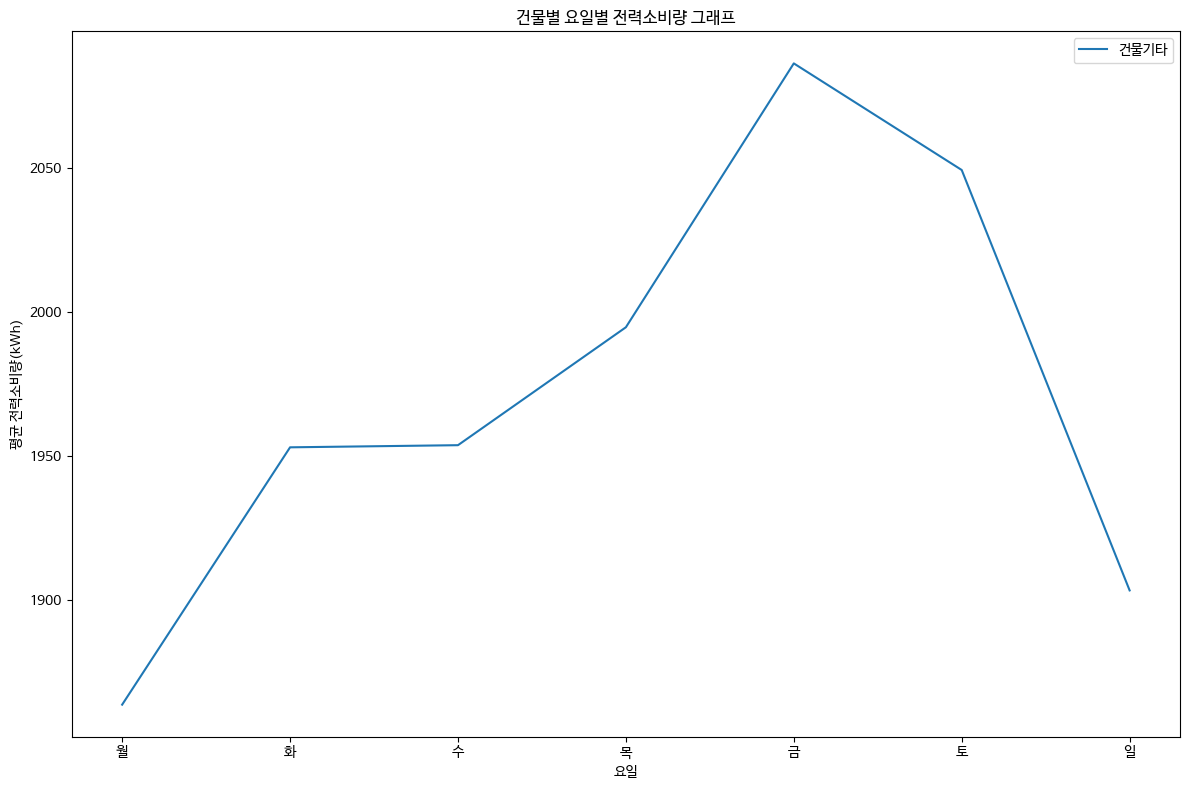

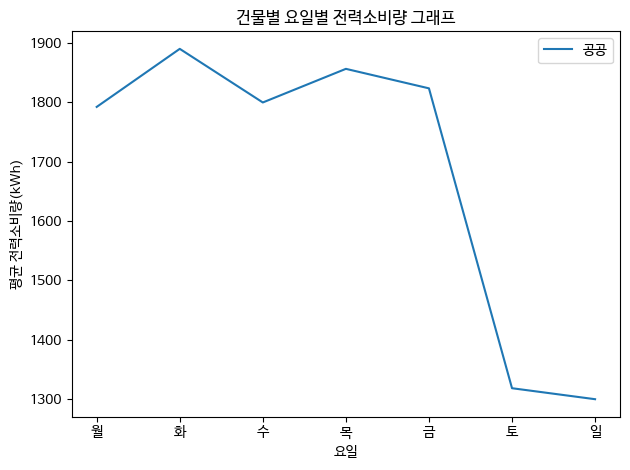

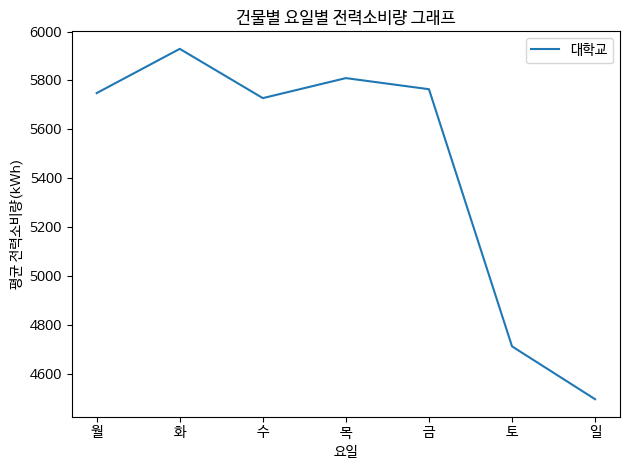

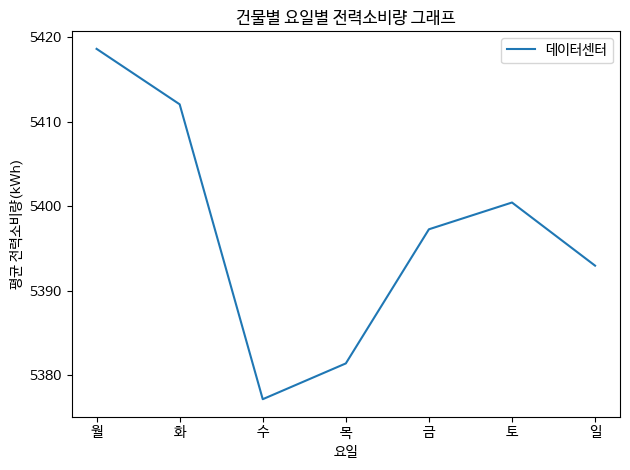

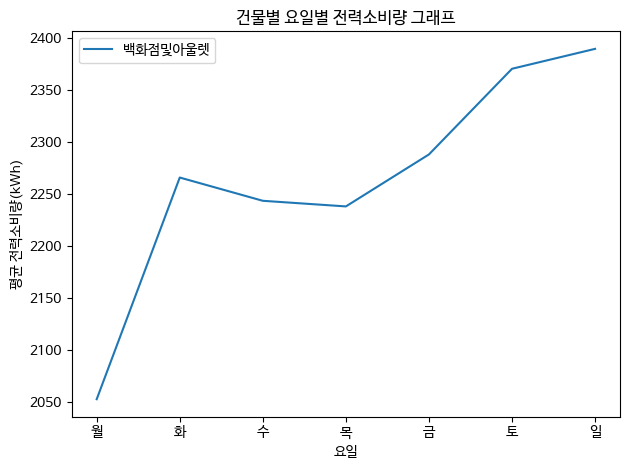

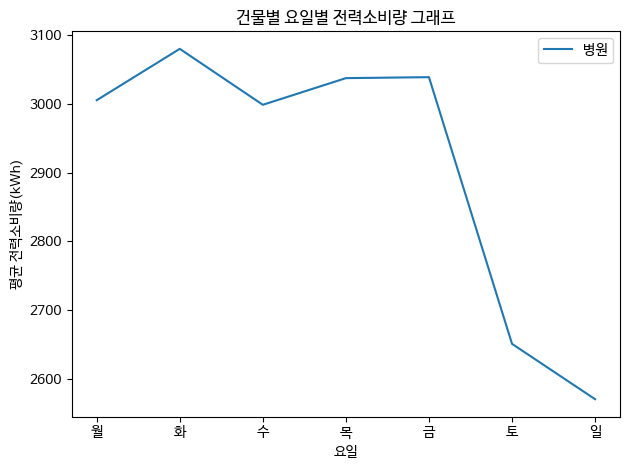

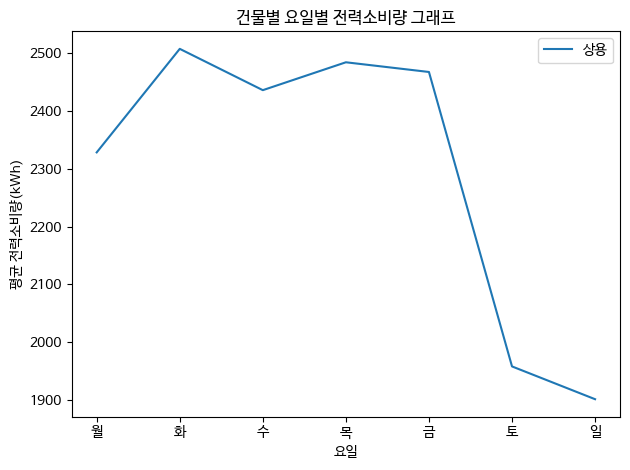

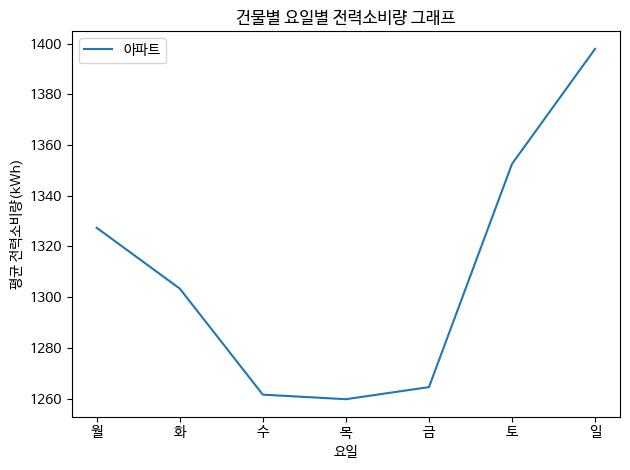

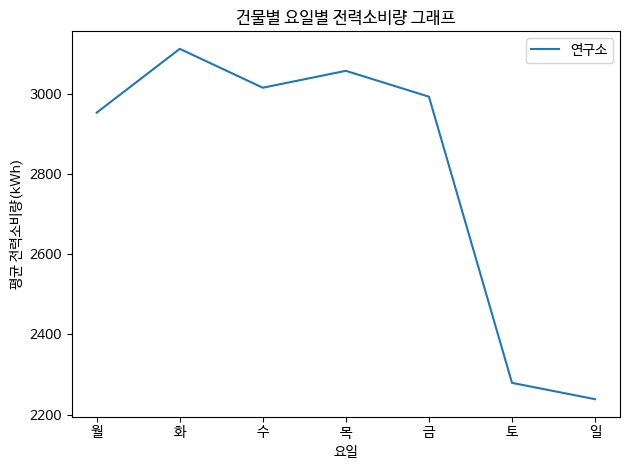

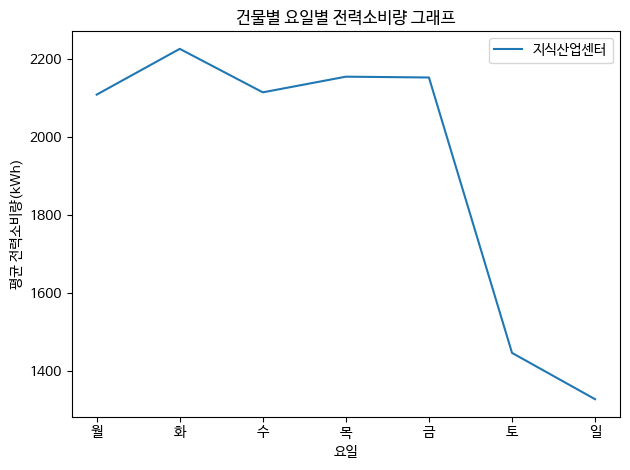

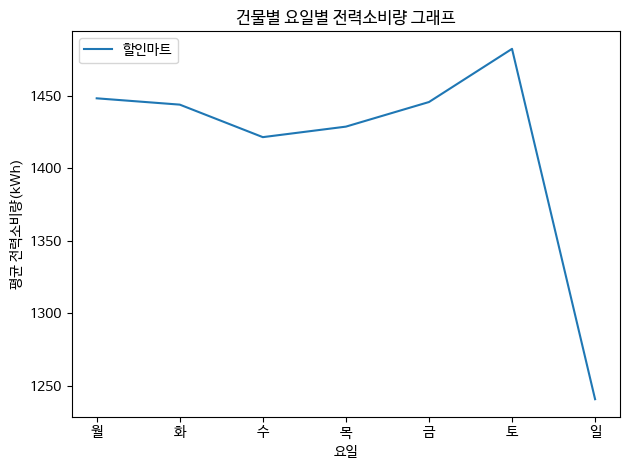

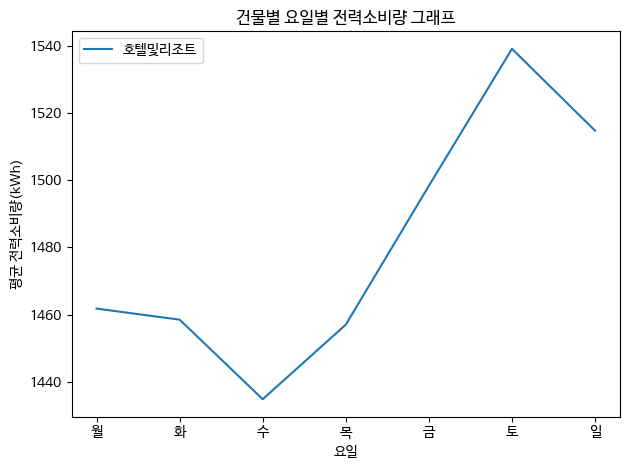

In [ ]:
# 건물별로 요일별 전력소비량 평균 계산
grouped = combined_df.groupby(['건물유형', '요일'])['전력소비량(kWh)'].mean().reset_index()

# 각 건물유형별로 요일별 전력소비량 그래프 그리기
unique_building_types = combined_df['건물유형'].unique()

plt.figure(figsize=(12, 8))
for building_type in unique_building_types:
    building_group = grouped[grouped['건물유형'] == building_type]
    plt.plot(building_group['요일'], building_group['전력소비량(kWh)'], label=building_type)

    plt.xlabel('요일')
    plt.ylabel('평균 전력소비량(kWh)')
    plt.title('건물별 요일별 전력소비량 그래프')
    plt.xticks(range(7), ['월', '화', '수', '목', '금', '토', '일'])  # X축 라벨을 요일명으로 설정
    plt.legend()
    plt.tight_layout()
    plt.show()